This notebook implements a CNN image classigier 

In [1]:
# !pip install torch==1.12.1

from fastai.vision import *
import fastai
from fastai.test_utils import *
from fastcore.all import L, setify
from pathlib import Path
import torch
import os
import fastbook
fastbook.setup_book()
from fastai.vision.widgets import *
from fastbook import *
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/scratch/jcbolo/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
path = Path('./step_1_visualization_hires')
print(parent_label(path))
path = Path('./snippet_library_test_synthetic_white/merged_experiments')  # ~28% error rate after 15 epochs
path = Path('./snippet_library_test_timeWarp_white/merged_experiments')  # ~89% error rate after 15 epochs
path = Path('./snippet_library_test_singleLetters_white/merged_experiments')  # ~88% error rate after 15 epochs

In [3]:
path = Path('./merged_dataset')  

In [4]:
files = get_image_files(path)

In [5]:
chars = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=CropPad((256,256), pad_mode = PadMode.Zeros)
)
#   
#     item_tfms=Resize(128*4))

In [6]:
dls = chars.dataloaders(path)
# dls.train.show_batch(max_n=1, nrows=1, unique=True)


None


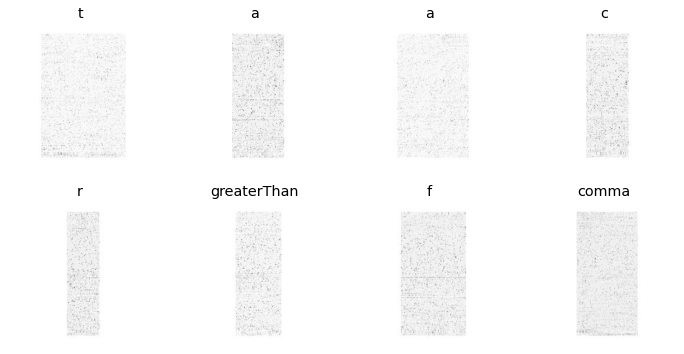

In [7]:
print(dls.train.show_batch(max_n=8, nrows=2, unique=False))

In [8]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
# learn.fine_tune(150)

/scratch/jcbolo/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/jcbolo/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
learn.fine_tune(100)

epoch,train_loss,valid_loss,error_rate,time
0,3.483068,3.108457,0.860307,04:21


epoch,train_loss,valid_loss,error_rate,time
0,2.739938,2.478613,0.717992,05:50
1,2.154421,2.072508,0.610274,05:53
2,1.629568,1.864321,0.556808,05:51
3,1.202427,1.801996,0.527716,05:52
4,0.799186,1.875792,0.513825,05:51
5,0.485610,2.104118,0.522343,05:52
6,0.323911,2.180277,0.510156,05:48
7,0.261996,2.319788,0.505307,05:50
8,0.268592,2.352352,0.502817,05:52
9,0.259393,2.378736,0.501114,05:50


In [ ]:
model = learn.model.eval()
image_path = './snippet_library_test_synthetic_white/merged_experiments/a/0.jpg'
pred = learn.predict(image_path)
cls = int(pred[1])
pred

In [ ]:
def gradCAM(image_path, learn, savepath, saveCompound=True, saveHeatmap=False):
    model = learn.model.eval()
    pred = learn.predict(image_path)
    cls = int(pred[1])
    img = PILImage.create(image_path)
    x, = first(dls.test_dl([img]))
    
    with hook_output(model[0], grad=True) as hook_a:
        with hook_output(model[0], grad=True) as hook_g:
            preds = model(x)
#             print(preds.shape)
            preds[0, cls].backward()
    acts = hook_a.stored[0].cpu()
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    mult = ((acts * grad_chan[..., None, None])).sum(0).sum(0)

    x_dec = TensorImage(dls.train.decode((x,))[0][0])
#     print(x_dec.shape)
    if saveCompound:
        _,ax = plt.subplots()
        x_dec.show(ctx=ax)
        ax.imshow(mult.detach().cpu(), alpha=0.6, extent=(0,x_dec.shape[2],x_dec.shape[1],0),
                      interpolation='bilinear', cmap='magma');
#         plt.savefig(savepath)
#         plt.close()
    if saveHeatmap:
        _,ax = plt.subplots()
        plt.grid(b=None)
        plt.axis('off')
        ax.imshow(mult.detach().cpu())
        plt.savefig(savepath)
        plt.close()
    return mult, acts, grad, x_dec

In [ ]:
from PIL import Image
image_path = './snippet_library_test_synthetic_white/merged_experiments/q/3.jpg'
mult, _, _, x_dec = gradCAM(image_path, learn, './test_1.png', saveCompound=True, saveHeatmap = True)
show_image(mult)

In [ ]:
# print(mult[2].shape)

x_dec = TensorImage(dls.train.decode((x,))[0][0])
print(x_dec.shape)
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(mult.detach().cpu(), alpha=0.6, extent=(0,x_dec.shape[2],x_dec.shape[1],0),
              interpolation='bilinear', cmap='magma');



In [ ]:
# print(mult[2].shape)

x_dec = TensorImage(dls.train.decode((x,))[0][0])
print(x_dec.shape)
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(mult.detach().cpu(), alpha=0.6, extent=(0,x_dec.shape[2],x_dec.shape[1],0),
              interpolation='bilinear', cmap='magma');



In [ ]:
# print(mult[2].shape)

x_dec = TensorImage(dls.train.decode((x,))[0][0])
print(x_dec.shape)
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(mult.detach().cpu(), alpha=0.6, extent=(0,x_dec.shape[2],x_dec.shape[1],0),
              interpolation='bilinear', cmap='magma');


In [ ]:
from glob import glob
import os

# os.mkdir('./CAM_snippet_library_full')
# os.mkdir('./CAM_snippet_library_full/merged_experiments/')
image_path = './snippet_library/t5.2019.05.08/a/3.png'

for folder in glob('./snippet_library_test_synthetic_white/merged_experiments/*'):
    newFolder = folder.replace('snippet_library_test_synthetic_white','CAM_snippet_library_full')
    if not os.path.isdir(newFolder):
        os.mkdir(newFolder)
    for img in glob(folder + '/*'):
        gradCAM(img, learn, img.replace('snippet_library_test_synthetic_white','CAM_snippet_library_full'))

In [ ]:
os.mkdir('./CAM_snippet_library_samples')
os.mkdir('./CAM_snippet_library_samples/merged_experiments/')
for folder in glob('./snippet_library_test_synthetic_white/merged_experiments/*'):
    newFolder = folder.replace('snippet_library_test_synthetic_white','CAM_snippet_library_samples')
    if not os.path.isdir(newFolder):
        os.mkdir(newFolder)
    imgs = np.asarray(glob(folder + '/*'))
    subset = np.random.choice(imgs, 10)
    for img in subset:
        gradCAM(img, learn, img.replace('snippet_library_test_synthetic_white','CAM_snippet_library_samples'))

In [ ]:
# from sewar.full_ref import mse

char_vectors = {}
for folder in glob('./snippet_library_test_synthetic_white/merged_experiments/*'):
    newFolder = folder.replace('snippet_library_test_synthetic_white','CAM_snippet_library_samples')
    print(newFolder.split('/')[-1])
    imgs = np.asarray(glob(folder + '/*'))
    subset = np.random.choice(imgs, 10)
    vector_arrays = []
    for img in subset:
        mult, _, _, _ = gradCAM(img, learn, img.replace('snippet_library_test_synthetic_white','CAM_snippet_library_samples'), False, False)
        vector_arrays.append(mult)
    char_vectors.update({newFolder.split('/')[-1]: vector_arrays})  

In [ ]:
for key in char_vectors.keys():
    for item in char_vectors[key]:
        show_image(item)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err


# print(char_vectors['a'][0])
# print(type(char_vectors['a'][0].numpy()))

# print(mse(char_vectors['a'][0].numpy(), char_vectors['apostrophe'][1].numpy()))
data = []
labels = []
for key in char_vectors.keys():
    data += char_vectors[key]
    labels += ([key]*10)
#     char_vectors[key] = [x.numpy() for x in char_vectors[key]]

avg=0
ct = 0
for i in range(10):
    for j in range(10):
        if i != j:
            avg += np.average(mse(char_vectors['c'][i], char_vectors['c'][j]))
            ct += 1
print('average internal similarity score:', avg/ct)
avg=0
ct = 0
for i in range(10):
    for j in range(10):
        for key in char_vectors.keys():
            if key != 'c':
                avg += np.average(mse(char_vectors['c'][i], char_vectors[key][j]))
                ct += 1
print('average external similarity score:', avg/ct)
np.average(mse(char_vectors['a'][1], char_vectors['c'][1]))

In [ ]:
!pip install git+https://github.com/lmcinnes/umap
    
import umap
import umap.plot

character_embedding = umap.UMAP() #metric = 'correlation', n_neighbors=15, min_dist=0.0,spread= 1, n_components=2, random_state=0).fit(data)